In [1]:
import tensorflow as tf

In [2]:
print(f'TensorFlow Versiom = {tf.__version__}')

if not tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
):
    raise RuntimeError('no GPU available')

TensorFlow Versiom = 2.0.0


In [13]:
from interstellar import Data, grid
import numpy as np
%matplotlib inline

In [4]:
data_path = '/rds/projects/d/daviesgr-cartography/mesa_grid/grid2_zams_agb/simple_grid_alex/'
data_cols = ['initial_mass', 'initial_Yinit', 'initial_feh', 'initial_MLT', 'evol_stage',
             'star_mass', 'star_age', 'frac_age', 'effective_T', 'luminosity', 'radius', 'star_feh',
             'delta_nu_fit']

tracks = Data()
tracks.load_all(path_to_data=data_path, usecols=data_cols)

In [205]:
tracks.select_evolution(stages=['dwarf', 'giant'], inplace=True)
data = tracks.data.sample(frac=0.2)  # Resample and reduce for testing
data['initial_tenfeh'] = 10**data['initial_feh']
data['star_tenfeh'] = 10**data['star_feh']

data.head()

Selecting Models at MS Phase with "dwarf"
Selecting Models at Subgiant and Red-giant phases with "giant"


,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_mass,star_age,frac_age,effective_T,luminosity,radius,star_feh,delta_nu_fit,initial_tenfeh,star_tenfeh
10439713,2,1.10,0.24,-0.2,1.9,1.095956,7.309578,1.363157,5020.847637,3.976134,2.638975,-0.209060,33.169929,0.630957,0.617931
9870393,2,1.17,0.30,-0.5,2.3,1.169823,2.307537,0.989664,7306.233116,6.069215,1.539707,-0.765169,71.140356,0.316228,0.171724
7084608,2,1.07,0.28,-0.4,2.3,1.065717,5.103172,1.397830,5384.940989,5.375899,2.667611,-0.409632,32.091428,0.398107,0.389375
6454241,1,1.05,0.24,0.0,1.9,1.050000,2.261107,0.277839,5756.461324,0.995033,1.004307,-0.035678,138.097004,1.000000,0.921132
1266278,2,0.85,0.32,0.3,1.5,0.848014,17.619708,1.213255,4954.672598,1.190561,1.482876,0.232457,70.463084,1.995262,1.707878


In [6]:
x_cols = ['initial_mass', 'frac_age', 'initial_tenfeh', 'initial_MLT', 'initial_Yinit']
y_cols = ['effective_T', 'radius', 'delta_nu_fit', 'star_tenfeh', 'star_age']

/rds/bear-apps/2019b/EL7-haswell/software/IPython/7.9.0-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/rds/bear-apps/2019b/EL7-haswell/software/IPython/7.9.0-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


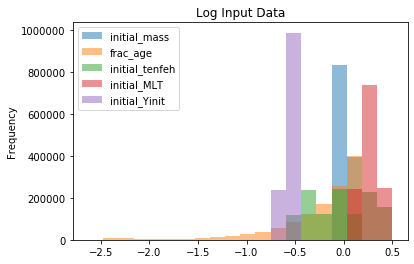

In [18]:
ax = np.log10(data).plot(kind='hist', y=x_cols, bins=20, alpha=0.5)
ax.set_title('Log Input Data');

/rds/bear-apps/2019b/EL7-haswell/software/IPython/7.9.0-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/rds/bear-apps/2019b/EL7-haswell/software/IPython/7.9.0-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Log Output Data')

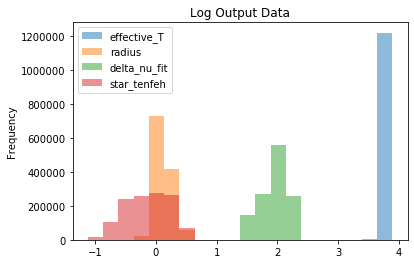

In [19]:
ax = np.log10(data).plot(kind='hist', y=y_cols, bins=20, alpha=0.5)
ax.set_title('Log Output Data')

In [26]:
arch = [[len(x_cols), 128, 128, 128, 128, 128, len(y_cols)], [len(x_cols), 256, 256, 256, 256, 256, len(y_cols)]]
activation = ['elu', 'relu']
l2s = [1e-10]

g = grid(data, x_cols, y_cols,
          arch=arch, activation=activation, l2s=l2s)

In [27]:
g(1000, batch_fraction=0.1)

Model : 00000
Median in y_0 : 0.010950
Median in y_1 : 0.023159
Median in y_2 : 0.011678
Median in y_3 : 0.032135
Model : 00100
Median in y_0 : 0.037052
Median in y_1 : 0.012993
Median in y_2 : 0.029255
Median in y_3 : 0.023047
Model : 01000
Median in y_0 : 0.013562
Median in y_1 : 0.022630
Median in y_2 : 0.015808
Median in y_3 : 0.037869
Model : 01100
Median in y_0 : 0.027634
Median in y_1 : 0.010950
Median in y_2 : 0.014548
Median in y_3 : 0.042387


In [155]:
mass = 1.0
fage = 1.0
tenfeh = 10**0.035
mlt = 1.9
yi = 0.265

In [156]:
xx = np.log10([[mass, fage, tenfeh, mlt, yi]])

In [157]:
n = 1000
fage = np.linspace(0+1/n, 1+1/n, n)

In [158]:
xx = xx*np.ones((n, 5))

In [159]:
xx[:, 1] = np.log10(fage)

In [160]:
yy = g.nn_dict['00000'].model.predict(xx)

In [161]:
solar_teff = 5777  # kelvin

Text(0, 0.5, 'log R/Rsun')

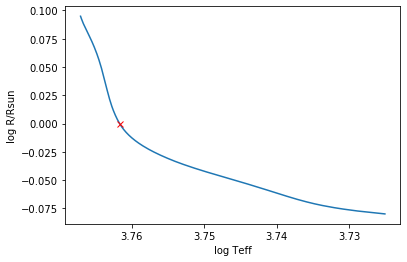

In [162]:
plt.plot(*yy[:, 0:2].T)
plt.plot(np.log10(solar_teff), 0.0, 'rx')
plt.gca().invert_xaxis()
plt.xlabel('log Teff')
plt.ylabel('log R/Rsun')

In [163]:
log_L = 4 * (yy[:, 0] - np.log10(solar_teff)) + 2 * yy[:, 1]

Text(0, 0.5, 'log L/Lsun')

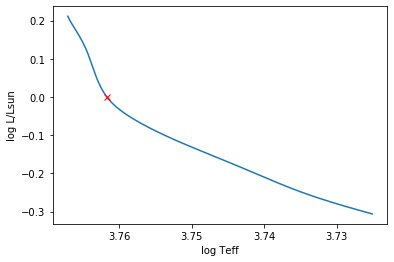

In [164]:
plt.plot(yy[:, 0], log_L)
plt.plot(np.log10(solar_teff), 0.0, 'rx')
plt.gca().invert_xaxis()
plt.xlabel('log Teff')
plt.ylabel('log L/Lsun')

In [214]:
axis_values = {'initial_mass': [0.9, 1.0, 1.1],
               'frac_age': np.linspace(0+1/100., 1.2, 100),
               'initial_tenfeh': 10**np.array([-0.1, 0.0, 0.1]),
               'initial_MLT': [1.9],
               'initial_Yinit': [0.26]}

In [215]:
testdata = Data(axis_values=axis_values)

In [220]:
testcols = testdata.grid_points.columns

In [216]:
xx = np.log10(testdata.grid_points.to_numpy())

In [217]:
yy = g.nn_dict['00000'].model.predict(xx)

In [218]:
log_L = 4 * (yy[:, 0] - np.log10(solar_teff)) + 2 * yy[:, 1]

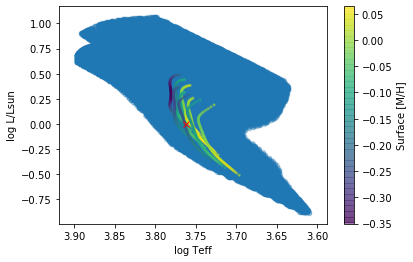

In [213]:

np.log10(data[data[testcols]==testdata]).plot(kind='scatter', x='effective_T', y='luminosity', alpha=0.2)
s = plt.scatter(yy[:, 0], log_L, c=yy[:, 3], s=4, alpha=0.5)
plt.plot(np.log10(solar_teff), 0.0, 'rx')
plt.gca().invert_xaxis()
plt.xlabel('log Teff')
plt.ylabel('log L/Lsun')
plt.colorbar(s, label='Surface [M/H]')

In [211]:
data.head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_mass,star_age,frac_age,effective_T,luminosity,radius,star_feh,delta_nu_fit,initial_tenfeh,star_tenfeh
10439713,2,1.10,0.24,-0.2,1.9,1.095956,7.309578,1.363157,5020.847637,3.976134,2.638975,-0.209060,33.169929,0.630957,0.617931
9870393,2,1.17,0.30,-0.5,2.3,1.169823,2.307537,0.989664,7306.233116,6.069215,1.539707,-0.765169,71.140356,0.316228,0.171724
7084608,2,1.07,0.28,-0.4,2.3,1.065717,5.103172,1.397830,5384.940989,5.375899,2.667611,-0.409632,32.091428,0.398107,0.389375
6454241,1,1.05,0.24,0.0,1.9,1.050000,2.261107,0.277839,5756.461324,0.995033,1.004307,-0.035678,138.097004,1.000000,0.921132
1266278,2,0.85,0.32,0.3,1.5,0.848014,17.619708,1.213255,4954.672598,1.190561,1.482876,0.232457,70.463084,1.995262,1.707878
